<a href="https://colab.research.google.com/github/JustChandy/BagOfWordsClassifier/blob/main/MainCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 3 - Sentiment
Classification**


The aim of this assignment is to create a Bag of Words (BoW) text classifier to do sentiment analysis of a list of restautant reviews and classify them as 'Positive', 'Negative' or "Neutral' 

In [ ]:
import pandas as pd
import numpy as np
import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize, sent_tokenize
import re

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Step 1 : Read data

In [ ]:
rev_data = pd.read_csv('reviews.csv', delimiter= '\t')

In [ ]:
rev_data.head

<bound method NDFrame.head of                        Name  ...                                             Review
0              Playa Cabana  ...  I was tasked with finding a spot for a group d...
1              Playa Cabana  ...  Went here with my friends and family. I liked ...
2              Playa Cabana  ...  Surprisingly good Flautas! They came as 3 roll...
3              Playa Cabana  ...  As a Mexican I always crave authentic Mexican ...
4              Playa Cabana  ...  Best tacos I've ever had. Both locations are g...
...                     ...  ...                                                ...
1915  Greedy Duck & Noodles  ...  Maybe I didn't know what to expect but the win...
1916  Greedy Duck & Noodles  ...  This is a casual family run restaurant. It's h...
1917  Greedy Duck & Noodles  ...  Very tasty and unique flavours. This has becom...
1918  Greedy Duck & Noodles  ...  The dry noodles are pretty good, super strong ...
1919  Greedy Duck & Noodles  ...  This is hand

Step 2 : Create Sentiment column to bin the rating values

In [ ]:
# Creating an extra column Sentiment based on RatingValue
conditions = [
      (rev_data['RatingValue'] <= 2),
      (rev_data['RatingValue'] == 3),
      (rev_data['RatingValue'] >= 4) 
      ]

values = ['Negative', 'Neutral', 'Positive']

rev_data['Sentiment'] = np.select(conditions, values)


In [ ]:
rev_data.head()

,Name,RatingValue,DatePublished,Review,Sentiment
0,Playa Cabana,4,2020-02-26,I was tasked with finding a spot for a group d...,Positive
1,Playa Cabana,3,2019-08-04,Went here with my friends and family. I liked ...,Neutral
2,Playa Cabana,3,2019-08-24,Surprisingly good Flautas! They came as 3 roll...,Neutral
3,Playa Cabana,4,2019-06-06,As a Mexican I always crave authentic Mexican ...,Positive
4,Playa Cabana,5,2020-05-25,Best tacos I've ever had. Both locations are g...,Positive


Step 3: Create a new data frame with RatingValue, Review and Sentiment columns from the original dataset

In [ ]:
new_revdata = rev_data[['Review', 'RatingValue', 'Sentiment']].copy()
new_revdata.head()

,Review,RatingValue,Sentiment
0,I was tasked with finding a spot for a group d...,4,Positive
1,Went here with my friends and family. I liked ...,3,Neutral
2,Surprisingly good Flautas! They came as 3 roll...,3,Neutral
3,As a Mexican I always crave authentic Mexican ...,4,Positive
4,Best tacos I've ever had. Both locations are g...,5,Positive


Step 4: Analyze different levels of Sentiment variable


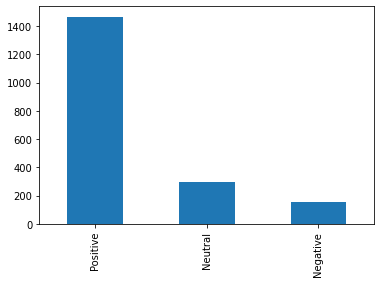

In [ ]:
new_revdata['Sentiment'].value_counts().plot(kind='bar')

Step 5: Balance the data

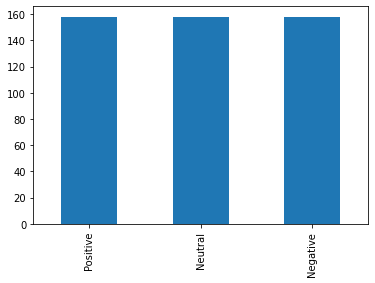

In [ ]:
# Shuffle the Dataset.
shuffled_df = new_revdata.sample(frac=1,random_state=4)

# Put all the negative class in a separate dataset.
neg_df = shuffled_df.loc[shuffled_df['Sentiment'] == 'Negative']

#Randomly select 158 observations from the Neutral (majority class)
neut_df = shuffled_df.loc[shuffled_df['Sentiment'] == 'Neutral'].sample(n=158,random_state=42)

#Randomly select 158 observations from the Posotive (majority class)
pos_df = shuffled_df.loc[shuffled_df['Sentiment'] == 'Positive'].sample(n=158,random_state=42)

# Concatenate 3 dataframes again
bal_reviews = pd.concat([pos_df, neg_df, neut_df])

#plot the dataset after the undersampling
bal_reviews['Sentiment'].value_counts().plot(kind='bar')

In [ ]:
#Reset the index of the balanced dataset for further processing
bal_reviews = bal_reviews.reset_index(drop=True)

Step 6: Create a dataset containing the corpus and another dataset containing the labels  

In [ ]:
X, y = bal_reviews['Review'], bal_reviews['Sentiment']

Step 7: Split the Corpus and Labels into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.30, random_state = 42)
train_ds, valid_ds =  train_test_split(rev_data , test_size = 0.30, random_state = 42)
train_ds.to_csv('training.csv')
valid_ds.to_csv('valid.csv')

In [ ]:
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

In [ ]:
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

Step 8: Normalize documents in the training corpus

In [ ]:
  documents_train=[] 
  for sen in range(0, len(X_train)):  
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X_train[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents_train.append(document)
  

Step 9: Normalize documents in the validation corpus

In [ ]:
  documents_valid=[] 
  for sen in range(0, len(X_valid)): 
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X_valid[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents_valid.append(document)

Step 10 : Create BoW representaiton of training and validation corpus

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, stop_words=stopwords.words('english'))
X_train = vectorizer.fit_transform(documents_train).toarray()
X_valid = vectorizer.fit_transform(documents_valid).toarray()

Step 11: Fit the BoW classifier to training set and create predictions on the validation set

In [ ]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_valid)

Step 12 : Evaluate performance of the classifier

Confusion Matrix:
 [[16 10 12]
 [24 11 12]
 [28 13 17]]


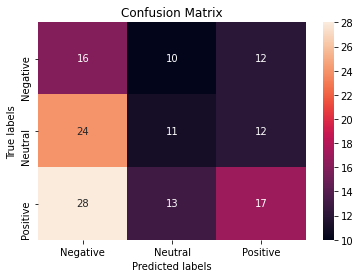

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
labels = ['Negative', 'Neutral', 'Positive']
cm = confusion_matrix(y_valid, y_pred, labels)
print ("Confusion Matrix:\n",cm)

#plot the confusion matrix 

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);




In [ ]:
# Accuracy, Precision and Recall
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy = accuracy_score(y_valid,y_pred)
precision = precision_score(y_valid,y_pred, average='micro')
recall = recall_score(y_valid,y_pred, average='micro' )
F1_Score = f1_score(y_valid, y_pred, average='micro')
print("\n")
print("Accuracy is ",round(score1*100,2),"%")
print("Precision is ",round(score2,2,))
print("Recall is ",round(score3,2))
print("F1 score is ", round(F1_Score,2))



Accuracy is  66.43 %
Precision is  0.66
Recall is  0.66
F1 score is  0.31


References: <br>
https://scikit-learn.org <br>
https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c<br>
https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn<br>
https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels